In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

sns.set()

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.head()

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,0,-2.033875,0.978446,-0.142131,-0.177117,-1.470684,1.669562,-0.196530,-0.125239,-0.452284,...,-1.111266,0.716084,0.060039,0.301279,-1.174846,-1.076498,-0.069452,-0.604012,-2.179176,0.558003
1,1,-0.348835,0.294815,-0.557577,-2.020773,-1.234715,1.633930,-1.680658,-0.358146,0.166122,...,0.735240,0.829781,1.521941,1.347946,0.754505,1.330642,-0.754453,0.582956,0.252671,1.495870
2,1,0.113248,-0.607726,-0.947791,0.830851,0.998291,0.498321,-1.493958,0.789572,-1.311018,...,0.104698,0.616189,-1.035953,2.111387,-0.984415,1.148076,-1.433554,0.243372,0.170083,1.274795
3,0,1.223321,-0.479048,-1.925789,1.680377,0.021840,-1.453307,0.605559,-0.019024,1.065448,...,0.360237,-1.957863,-0.123384,1.505329,0.660290,-1.769443,-0.547756,-0.568122,0.244645,0.982116
4,0,0.160109,0.422684,-0.308029,0.227744,0.432854,0.608348,0.193832,1.035091,-0.538868,...,0.416629,1.441766,0.212572,-0.994721,1.143999,-2.166923,-1.199248,-1.028636,0.752791,0.317169


In [5]:
data.isnull().sum()

labels    0
f_0       0
f_1       0
f_2       0
f_3       0
         ..
f_1195    0
f_1196    0
f_1197    0
f_1198    0
f_1199    0
Length: 1201, dtype: int64

In [6]:
data.shape

(5250, 1201)

In [7]:
dep = data["labels"]
indep = data.drop(columns=["labels"])

In [8]:
test_data = pd.read_csv("test.csv")
test_data.head()

,id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,1,-3.388242,0.868285,-0.427619,-0.678964,-1.625735,0.262761,1.243040,1.537751,-0.352028,...,-0.776403,-0.662884,-0.257091,-1.168413,0.223260,-0.482520,-0.085453,-0.382265,-0.539349,-1.682404
1,2,-0.496920,0.952381,0.989040,0.451422,0.513516,-0.099658,-1.124326,0.729430,-0.216224,...,0.379635,-1.760084,1.125450,-0.328047,-0.880305,-1.257607,0.964312,2.021104,0.655021,-0.423029
2,3,1.128369,-0.537951,2.544358,1.165254,-1.904994,0.776961,-0.495768,0.060111,-1.418468,...,1.165254,-1.373589,-0.483701,-0.964782,-0.869555,0.066040,-0.444567,-0.531935,-0.878660,1.099488
3,4,0.051253,1.746814,0.681177,1.844524,-0.327977,1.226839,-0.085519,0.379008,-1.003667,...,-0.442288,-2.794472,-0.763468,-0.789832,-0.113209,-2.703150,-2.058728,1.070627,-0.458045,-0.435825
4,5,1.423209,-0.983594,-1.694170,1.197507,1.044211,0.518777,-0.298612,-0.365174,0.738447,...,-2.624450,-3.200223,0.711422,-0.190394,0.337224,-1.656639,0.707360,-0.562290,1.471181,-0.192000


In [9]:
test_indep = test_data.drop(columns = ['id'])
test_indep

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,-3.388242,0.868285,-0.427619,-0.678964,-1.625735,0.262761,1.243040,1.537751,-0.352028,-0.114245,...,-0.776403,-0.662884,-0.257091,-1.168413,0.223260,-0.482520,-0.085453,-0.382265,-0.539349,-1.682404
1,-0.496920,0.952381,0.989040,0.451422,0.513516,-0.099658,-1.124326,0.729430,-0.216224,-0.000680,...,0.379635,-1.760084,1.125450,-0.328047,-0.880305,-1.257607,0.964312,2.021104,0.655021,-0.423029
2,1.128369,-0.537951,2.544358,1.165254,-1.904994,0.776961,-0.495768,0.060111,-1.418468,-0.086128,...,1.165254,-1.373589,-0.483701,-0.964782,-0.869555,0.066040,-0.444567,-0.531935,-0.878660,1.099488
3,0.051253,1.746814,0.681177,1.844524,-0.327977,1.226839,-0.085519,0.379008,-1.003667,0.570237,...,-0.442288,-2.794472,-0.763468,-0.789832,-0.113209,-2.703150,-2.058728,1.070627,-0.458045,-0.435825
4,1.423209,-0.983594,-1.694170,1.197507,1.044211,0.518777,-0.298612,-0.365174,0.738447,0.054435,...,-2.624450,-3.200223,0.711422,-0.190394,0.337224,-1.656639,0.707360,-0.562290,1.471181,-0.192000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0.889888,-0.319077,0.849589,0.822723,0.876455,0.325704,0.876455,-0.910127,0.889888,0.204808,...,0.889888,-2.226556,-0.090717,-1.393713,-0.896694,-0.399675,-0.856395,0.876455,0.863022,-0.601169
2246,1.005737,-0.064755,1.163494,1.163494,1.163494,0.724028,0.712760,-0.785929,-1.225394,1.107152,...,1.163494,-1.270468,-0.932417,-1.169053,-0.008414,-0.605636,-0.323927,1.163494,-1.315541,0.047928
2247,1.252086,1.223561,0.153859,-0.987156,0.239435,-0.003031,-1.158309,1.237823,-1.272410,0.767154,...,0.581740,-1.386512,0.809943,-1.243885,0.153859,-0.630589,1.594391,1.252086,-1.429300,1.408976
2248,1.042624,-0.129166,1.066538,1.030667,1.162195,0.707827,-1.396612,0.014319,-1.025944,0.982839,...,1.078495,-1.193343,0.086061,-0.081338,-0.978116,-0.368307,-0.129166,1.090452,-1.444440,0.468686


In [10]:
final_df = pd.DataFrame()
final_df = test_data[["id"]]
final_df

,id
0,1
1,2
2,3
3,4
4,5
...,...
2245,2246
2246,2247
2247,2248
2248,2249


In [56]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 1:                 
            print("\nReached 100% accuracy so cancelling training!")
            self.model.stop_training = True 

In [57]:
callbacks = myCallback()

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)


model.compile(optimizer=tf.keras.optimizers.Adam(), 
loss= "binary_crossentropy", 
metrics=['accuracy'])


In [58]:
history = model.fit(indep, dep, epochs = 50, callbacks=[callbacks])

Epoch 1/50
165/165 [==============================] - 1s 5ms/step - loss: 0.3846 - accuracy: 0.8173
Epoch 2/50
165/165 [==============================] - 1s 3ms/step - loss: 0.1910 - accuracy: 0.9280
Epoch 3/50
165/165 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9650
Epoch 4/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0561 - accuracy: 0.9825
Epoch 5/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 0.9910
Epoch 6/50
165/165 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9903
Epoch 7/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9910
Epoch 8/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9897
Epoch 9/50
165/165 [==============================] - 1s 3ms/step - loss: 0.0195 - accuracy: 0.9933
Epoch 10/50
165/165 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9962

In [59]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               153728    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 162,049
Trainable params: 162,049
Non-trainable params: 0
_________________________________________________________________


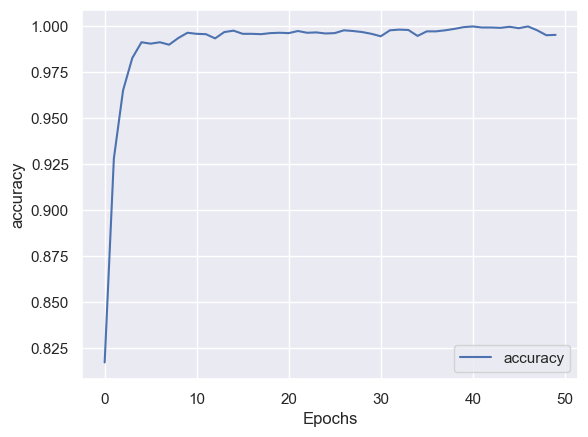

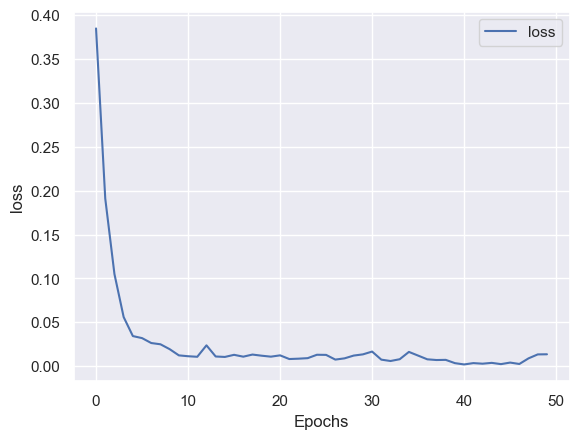

In [60]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [62]:
model_predictions = model.predict(test_indep)

lis = []

for x in model_predictions:
    if x >= 0.5:
        lis.append(1)
    else:
        lis.append(0)
lis

71/71 [==============================] - 0s 1ms/step


[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [63]:
len(lis)

2250

In [64]:
my_series = pd.Series(lis)
final_df["labels"] = lis

final_df

C:\Users\haris\AppData\Local\Temp\ipykernel_2660\959362348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = lis


,id,labels
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [45]:
final_df.to_csv("Final_Output.csv", index = False)

# DECISION TREE

In [23]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 9)
drugTree

DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [24]:
drugTree.fit(indep, dep)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

In [25]:
predTree = drugTree.predict(test_indep)

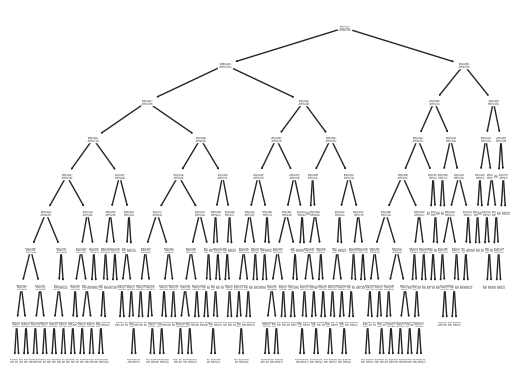

In [26]:
tree.plot_tree(drugTree)
plt.show()

In [27]:
my_series = pd.Series(predTree)
final_df["labels"] = predTree

final_df

C:\Users\haris\AppData\Local\Temp\ipykernel_18112\3614248246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = predTree


,id,labels
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [28]:
final_df.to_csv("Final_Output_Decision Tree.csv", index = False)

# XGBOOST ALGO

In [29]:
import xgboost as xgb

In [31]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=8,
    learning_rate=0.1,
    n_estimators=100
)

# Train the XGBoost model
model.fit(indep, dep)

# Make predictions on the test set
y_pred = model.predict(test_indep)

In [32]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [33]:
my_series = pd.Series(y_pred)
final_df["labels"] = y_pred

final_df

C:\Users\haris\AppData\Local\Temp\ipykernel_18112\2965317023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = y_pred


,id,labels
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [34]:
final_df.to_csv("Final_Output_XGBOOST.csv", index = False)

# LOGISTIC REGRESSION

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(indep,dep)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [36]:
yhat = LR.predict(test_indep)
yhat

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [37]:
yhat_prob = LR.predict_proba(test_indep)
yhat_prob

array([[6.62993695e-01, 3.37006305e-01],
       [6.58749131e-01, 3.41250869e-01],
       [5.83685935e-01, 4.16314065e-01],
       ...,
       [3.77574312e-02, 9.62242569e-01],
       [9.99959692e-01, 4.03077015e-05],
       [1.67639526e-01, 8.32360474e-01]])

In [38]:
my_series = pd.Series(yhat)
final_df["labels"] = yhat

final_df

C:\Users\haris\AppData\Local\Temp\ipykernel_18112\2878433479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["labels"] = yhat


,id,labels
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2245,2246,0
2246,2247,0
2247,2248,1
2248,2249,0


In [39]:
final_df.to_csv("Final_Output_LogiReg.csv", index = False)

In [ ]:
print("More models yet to come")

In [ ]:
print()
print()